# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.



## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1u0EczCmbDHea2N45Po1U0JnQ7494Z60w#scrollTo=rWiUqJJTa9z6

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
file = '/content/drive/My Drive/Colab Notebooks/APS360/Lab 5/SMSSpamCollection'

In [0]:
data = []
for line in open(file):
  data.append(line)
row = len(data)
print('Sample output of the data file:\n', data[0])
print('\nThere are %d lines of information in the document' %row)

Sample output of the data file:
 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


There are 5574 lines of information in the document


Spam messages = SPAM   |    Non-spam messages = HAM

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [0]:
num_spam = 0
for i in range(row):
  if 'spam' in data[i][0:4]:
    num_spam+=1
print('The number of spam messages in the dataset are: %d, and the number of non spam messages are %d' %(num_spam, row-num_spam))

The number of spam messages in the dataset are: 747, and the number of non spam messages are 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages: 

- will not be affected by mispelled words
- can model language better, so it can be easier to predict statements made by vernacular of people

Disadvantages: 

- lower accuracy results than word based
- higher computational cost

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset


In [0]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,     # to produce tensors with the batch dimension first
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      # is this what we are training to detect
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 (false; no spam) and 1 (true; spam)

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset(file, # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

#print(dataset[2].sms)
#print(dataset[2].label)

train_data, val_data, test_data = dataset.split(split_ratio = [0.6, 0.2, 0.2], # defining the train, val, test split ratios
                                                stratified=False,           # defining whether or not the same proportions of true/false exist
                                                strata_field='label',       # where the data is stratified over
                                                random_state=None)          #random state for shuffling

print('The number of data samples in the train/val/test sets are: %d, %d, %d, respectively' %(len(train_data), len(val_data), len(test_data)))

The number of data samples in the train/val/test sets are: 3343, 1115, 1114, respectively


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating non-spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

Answer: this is because if there is a high imbalance of one particular label, the model will bias itself towards predicting that specific label, which will not be representative towards a general case. 

In [0]:
# save the original training examples
old_train_examples = train_data.examples
# get all the spam messages in `train`
train_spam = []
for item in train_data.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_data.examples = old_train_examples + train_spam * 6


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [0]:
text_field.build_vocab(train_data) #Construct the Vocab object for this field from one or more datasets
dic = text_field.vocab.stoi # creates an index of all of the characters present with corresponding index numbers (string to index) 
dic2 = text_field.vocab.itos # index to string (gives the string character from the stoi index for each number which is inputted)


### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [0]:
'<unk> = unknown words'
'<pad> = padding added to make input sequences the same length'

'<pad> = padding added to make input sequences the same length'

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [0]:
train_iter = torchtext.data.BucketIterator(train_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [0]:
for batch in train_iter:
    game = batch.sms[0][0]
    break
    #print(len(batch))
    #print(batch.sms)
    #print(batch.label)



Maximum length of 10 random batches were as follows: 122, 101, 160, 160, 149, 108, 154, 126, 96, 155

Number of Pad tokens in each of the batches:  

In [0]:
### RANDOM CODE - PLAYING WITH HOW THE TEXT TENSORS WORK
gamee = game.tolist()
#print(gamee[0])
#print(dic2)
statement = ''
for i in range(len(gamee)):
  statement = statement+dic2[gamee[i]]
print(statement)

Ur cash-balance is currently 500 pounds - to maximize ur cash-in now send COLLECT to 83600 only 150p/msg. CC: 08718720201 PO BOX 114/14 TCR/W1


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [0]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident)
#print(ident[0]) # one-hot vector
#print(ident[1]) # one-hot vector
print(ident[x]) # one-hot vectors

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [0]:
char_list = text_field.vocab.itos
num_cat = len(char_list)
one_hots = torch.eye(num_cat)
print(dic2)
#print(one_hots)
#print(len(char_list))

['<unk>', '<pad>', ' ', 'e', 'o', 't', 'a', 'n', 'r', 'i', 's', 'l', 'u', 'h', '0', 'd', '.', 'c', 'm', 'y', 'w', 'p', 'g', '1', 'f', 'b', '2', '8', 'T', 'k', 'v', '5', 'E', 'S', 'C', '4', 'I', 'O', '7', 'x', 'N', '3', 'A', '6', '!', ',', '9', 'R', 'P', 'M', 'W', 'U', 'H', 'L', 'B', 'D', 'Y', '/', 'G', 'F', "'", '?', '£', '-', ':', 'X', '&', 'z', 'V', 'K', 'j', ')', 'J', '*', '+', ';', '(', 'q', '"', 'Q', '#', '>', '=', '@', 'ü', 'Z', 'Ü', '_', '‘', '|', '\x92', '$', '[', ']', '<', '\x93', '“', '%', '…', '–', '\\', '\x94', '\x96', 'é', '\t', '\n', '~', '\x91', '’', '»', 'É', 'è']


In [0]:
class Spammy(nn.Module): #NOTE: set number of RNN layers to default (1)
  def __init__(self, input_size, hidden_size):
    super(Spammy, self).__init__()
    self.name="spam_detect"
    self.ident = torch.eye(num_cat) #number of one-hot identifiers; one for each character
    self.hidden_size = hidden_size #number of hidden layers
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, 2) #generates an output of 0/1 (not spam or spam)
    
  def forward(self, x):
    # look at the embedding value
    x = self.ident[x]
    # Set an initial hidden state
    h = torch.zeros(1, x.size(0), self.hidden_size)
    # Forward propagate the RNN
    out, _ = self.rnn(x, h)
    # Pass the output of the last time step to the classifier
    out = self.fc(out[:, -1, :])
    return out


## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify the 
You may use `torchtext.data.BucketIterator` to make your computation
faster.

In [0]:
def get_accuracy(model, data):
  """ Compute the accuracy of the `model` across a dataset `data`

  Example usage:

  >>> model = MyRNN() # to be defined
  >>> get_accuracy(model, valid) # the variable `valid` is from above
  """       

  correct, total= 0, 0

  for sms, label in data:
    output= model(sms[0])
    pred= output.max(1, keepdim=True)[1]
    correct += pred.eq(label.view_as(pred)).sum().item()
    total += label.shape[0]
  return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [0]:
import matplotlib.pyplot as plt

def train_rnn(model, train, valid, num_epochs, batch_size, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    train_iter = torchtext.data.BucketIterator(
                    train,
                    batch_size=batch_size,
                    sort_key=lambda x: len(x.sms), # to minimize padding
                    sort_within_batch=True,        # sort within each batch
                    repeat=False)                  # repeat the iterator for many epochs
    valid_iter = torchtext.data.BucketIterator(
                    valid,
                    batch_size=batch_size,
                    sort_key=lambda x: len(x.sms), # to minimize padding
                    sort_within_batch=True,        # sort within each batch
                    repeat=False)                  # repeat the iterator for many epochs

    for epoch in range(num_epochs):
        for sms, label in train_iter:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
            
        losses.append(float(loss))     
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_iter))
        valid_acc.append(get_accuracy(model, valid_iter))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
            epoch+1, loss, train_acc[-1], valid_acc[-1]))
       
        # save model
        model_path = f"model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epoch}"
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.667386; Train Acc 0.528018; Val Acc 0.145291
Epoch 2; Loss 0.715086; Train Acc 0.534880; Val Acc 0.160538
Epoch 3; Loss 0.706103; Train Acc 0.557915; Val Acc 0.233184
Epoch 4; Loss 0.724803; Train Acc 0.596635; Val Acc 0.464574
Epoch 5; Loss 0.655113; Train Acc 0.629636; Val Acc 0.569507
Epoch 6; Loss 0.670518; Train Acc 0.724228; Val Acc 0.703139
Epoch 7; Loss 0.642782; Train Acc 0.869139; Val Acc 0.910314
Epoch 8; Loss 0.412752; Train Acc 0.883516; Val Acc 0.919283
Epoch 9; Loss 0.305377; Train Acc 0.893481; Val Acc 0.926457
Epoch 10; Loss 0.451174; Train Acc 0.893318; Val Acc 0.896861


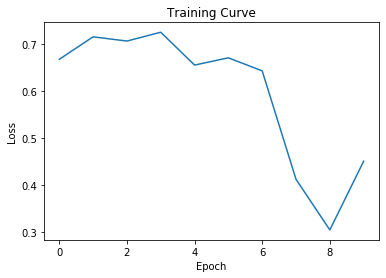

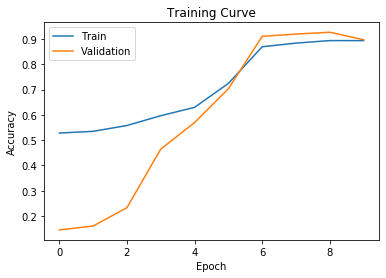

In [0]:
input_size= num_cat

spammy = Spammy(input_size, input_size);

train_rnn(spammy, train_data, val_data, num_epochs= 10, learning_rate=0.00001, batch_size= 32)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyper parameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [0]:
#hyperparater sets 
hp0 = [25, 32, 0.000025]
hp1 = [25, 64, 0.00005]
hidden_size0 = 150
hidden_size1 = 250

Epoch 1; Loss 0.194674; Train Acc 0.904264; Val Acc 0.934529
Epoch 2; Loss 0.354123; Train Acc 0.912596; Val Acc 0.929148
Epoch 3; Loss 0.353561; Train Acc 0.927626; Val Acc 0.914798
Epoch 4; Loss 0.336143; Train Acc 0.915373; Val Acc 0.934529
Epoch 5; Loss 0.373569; Train Acc 0.912596; Val Acc 0.947982
Epoch 6; Loss 0.390219; Train Acc 0.924849; Val Acc 0.939013
Epoch 7; Loss 0.439803; Train Acc 0.932364; Val Acc 0.919283
Epoch 8; Loss 0.055156; Train Acc 0.920274; Val Acc 0.953363
Epoch 9; Loss 0.155185; Train Acc 0.940696; Val Acc 0.942601
Epoch 10; Loss 0.115591; Train Acc 0.933671; Val Acc 0.949776
Epoch 11; Loss 0.171453; Train Acc 0.940859; Val Acc 0.951570
Epoch 12; Loss 0.313477; Train Acc 0.940859; Val Acc 0.952466
Epoch 13; Loss 0.169016; Train Acc 0.950825; Val Acc 0.931839
Epoch 14; Loss 0.322806; Train Acc 0.937755; Val Acc 0.890583
Epoch 15; Loss 0.252029; Train Acc 0.951805; Val Acc 0.944395
Epoch 16; Loss 0.126466; Train Acc 0.930894; Val Acc 0.961435
Epoch 17; Loss 0.

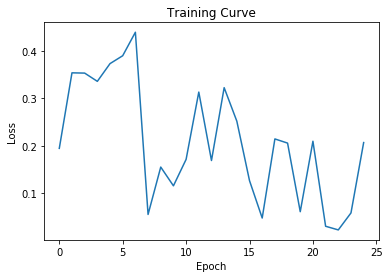

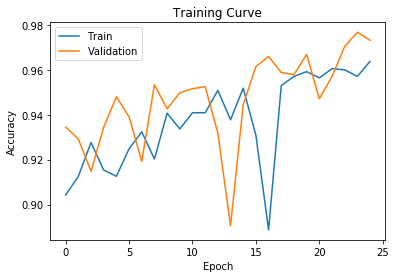

In [0]:
train_rnn(spammy, train_data, val_data, num_epochs= hp0[0], learning_rate=hp0[2], batch_size= hp0[1])

Epoch 1; Loss 0.365026; Train Acc 0.960137; Val Acc 0.958744
Epoch 2; Loss 0.070685; Train Acc 0.961934; Val Acc 0.974888
Epoch 3; Loss 0.074722; Train Acc 0.964548; Val Acc 0.965022
Epoch 4; Loss 0.169734; Train Acc 0.966019; Val Acc 0.964126
Epoch 5; Loss 0.038082; Train Acc 0.966345; Val Acc 0.959641
Epoch 6; Loss 0.555999; Train Acc 0.952459; Val Acc 0.965919
Epoch 7; Loss 0.014058; Train Acc 0.968142; Val Acc 0.964126
Epoch 8; Loss 0.047739; Train Acc 0.967162; Val Acc 0.977578
Epoch 9; Loss 0.023612; Train Acc 0.958177; Val Acc 0.979372
Epoch 10; Loss 0.145942; Train Acc 0.883843; Val Acc 0.783857
Epoch 11; Loss 0.021913; Train Acc 0.954092; Val Acc 0.981166
Epoch 12; Loss 0.029091; Train Acc 0.964548; Val Acc 0.973991
Epoch 13; Loss 0.060914; Train Acc 0.969449; Val Acc 0.975785
Epoch 14; Loss 0.022471; Train Acc 0.972717; Val Acc 0.975785
Epoch 15; Loss 0.142691; Train Acc 0.972390; Val Acc 0.970404
Epoch 16; Loss 0.050431; Train Acc 0.964222; Val Acc 0.947085
Epoch 17; Loss 0.

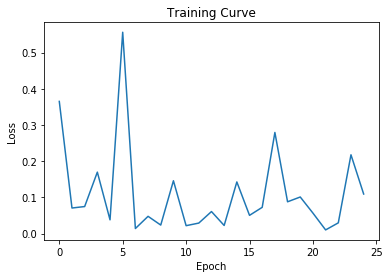

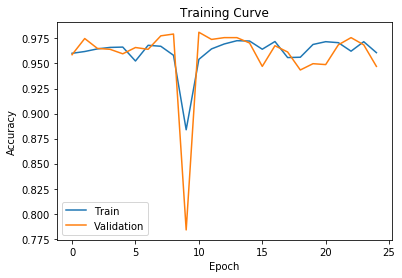

In [0]:
train_rnn(spammy, train_data, val_data, num_epochs= hp1[0], learning_rate=hp1[2], batch_size= hp1[1])

Epoch 1; Loss 0.709753; Train Acc 0.552851; Val Acc 0.156054
Epoch 2; Loss 0.714542; Train Acc 0.563470; Val Acc 0.160538
Epoch 3; Loss 0.724355; Train Acc 0.626695; Val Acc 0.230493
Epoch 4; Loss 0.663216; Train Acc 0.712955; Val Acc 0.735426
Epoch 5; Loss 0.317799; Train Acc 0.879758; Val Acc 0.928251
Epoch 6; Loss 0.702899; Train Acc 0.862114; Val Acc 0.916592
Epoch 7; Loss 0.076263; Train Acc 0.908512; Val Acc 0.943498
Epoch 8; Loss 0.140153; Train Acc 0.909165; Val Acc 0.944395
Epoch 9; Loss 0.211583; Train Acc 0.892501; Val Acc 0.947982
Epoch 10; Loss 0.115560; Train Acc 0.918641; Val Acc 0.899552
Epoch 11; Loss 0.111403; Train Acc 0.925339; Val Acc 0.950673
Epoch 12; Loss 0.037979; Train Acc 0.926156; Val Acc 0.947982
Epoch 13; Loss 0.088033; Train Acc 0.938082; Val Acc 0.946188
Epoch 14; Loss 0.198255; Train Acc 0.939062; Val Acc 0.935426
Epoch 15; Loss 0.379164; Train Acc 0.933017; Val Acc 0.913901
Epoch 16; Loss 0.111385; Train Acc 0.935631; Val Acc 0.954260
Epoch 17; Loss 0.

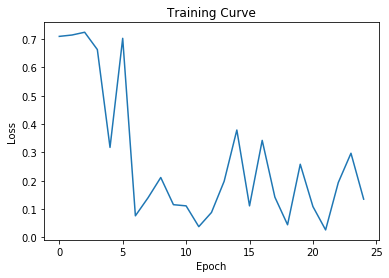

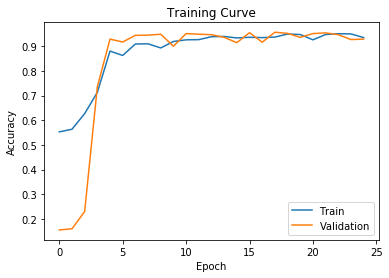

In [0]:
spammy = Spammy(input_size, hidden_size0)
train_rnn(spammy, train_data, val_data, num_epochs= hp1[0], learning_rate=hp1[2], batch_size= hp1[1])

Epoch 1; Loss 0.700450; Train Acc 0.535533; Val Acc 0.143498
Epoch 2; Loss 0.727227; Train Acc 0.595818; Val Acc 0.424215
Epoch 3; Loss 0.586660; Train Acc 0.818657; Val Acc 0.893274
Epoch 4; Loss 0.173433; Train Acc 0.892665; Val Acc 0.924664
Epoch 5; Loss 0.089097; Train Acc 0.923705; Val Acc 0.930045
Epoch 6; Loss 0.385552; Train Acc 0.925829; Val Acc 0.907623
Epoch 7; Loss 0.336402; Train Acc 0.774873; Val Acc 0.788341
Epoch 8; Loss 0.158555; Train Acc 0.916190; Val Acc 0.930942
Epoch 9; Loss 0.054834; Train Acc 0.928443; Val Acc 0.948879
Epoch 10; Loss 0.295798; Train Acc 0.543702; Val Acc 0.156951
Epoch 11; Loss 0.521002; Train Acc 0.769155; Val Acc 0.749776
Epoch 12; Loss 0.262581; Train Acc 0.844143; Val Acc 0.886099
Epoch 13; Loss 0.065997; Train Acc 0.938899; Val Acc 0.947085
Epoch 14; Loss 0.201309; Train Acc 0.938572; Val Acc 0.948879
Epoch 15; Loss 0.154648; Train Acc 0.941513; Val Acc 0.921076
Epoch 16; Loss 0.104281; Train Acc 0.950335; Val Acc 0.949776
Epoch 17; Loss 0.

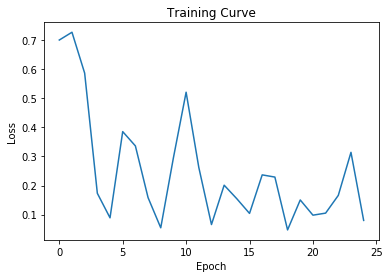

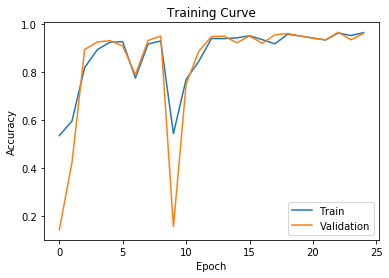

In [0]:
spammy = Spammy(input_size, hidden_size1)
train_rnn(spammy, train_data, val_data, num_epochs= hp1[0], learning_rate=hp1[2], batch_size= hp1[1])

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [0]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [s for s in val_data.examples if s.label == 1],
    val_data.fields)
valid_spam_stuff = torchtext.data.BucketIterator(
                    valid_spam,
                    batch_size=32,
                    sort_key=lambda x: len(x.sms), # to minimize padding
                    sort_within_batch=True,        # sort within each batch
                    repeat=False)                  # repeat the iterator for many epochs
# Create a Dataset of only non-spam validation examples

valid_nospam = torchtext.data.Dataset(
    [s for s in val_data.examples if s.label == 1],
    val_data.fields)

valid_nospam_stuff = torchtext.data.BucketIterator(
                    valid_spam,
                    batch_size=32,
                    sort_key=lambda x: len(x.sms), # to minimize padding
                    sort_within_batch=True,        # sort within each batch
                    repeat=False)                  # repeat the iterator for many epochs

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

The impact of a false positive could be detremental; because uncommon messages which are irregular (such as government information, polling info, bank stuff, etc.) could be sent to spam folders which could have a major impact 

False negatives cause an inconvenience for the individual, but it is not potentially catastrophic

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [0]:
testing_stuff = torchtext.data.BucketIterator(
                    test_data,
                    batch_size=64,
                    sort_key=lambda x: len(x.sms), # to minimize padding
                    sort_within_batch=True,        # sort within each batch
                    repeat=False)                  # repeat the iterator for many epochs
print("Final testing accuracy:", np.round(get_accuracy(spammy, testing_stuff), 4)*100,"%")

Final testing accuracy: 88.14999999999999 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [0]:
msg = "machine learning is sooo cool!"

In [0]:
swag_tensor= torch.tensor([[text_field.vocab.stoi[letter] for letter in msg]]) 
## Excuse the naming convention, I'm just putting the first names that pop in my head due to crunch time

In [0]:
spammy(swag_tensor)

tensor([[ 0.3104, -0.4623]], grad_fn=<AddmmBackward>)

Evidently, the output is not spam

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detecting spam is very difficult since spam messages try to emulate real messages (and are often decieving to try to persuade inviduals to do certain actions). As a result, the method for detecting these as a baseline model must be subtle. Typically, from personal experience, a lot of spam messages tend to contain many exclamation marks, dollar signs, or mispelled words (which could be estimated through many back-to-back consonants without vowel separation). As a result the baseline model could be something as simple as the pseudocode below:

input = message
baseline(input) #output is a 0 if not spam and 1 if spam

def baseline(input):
  if (number of back-to-back explanation marks>3 || number of back-to-back dollar signs are>2 || number of consonants back to back >5):
    return 1
  else
    return 0